<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Необходимо:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from statsmodels.tsa.stattools import adfuller
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [3]:
import os

In [4]:
pth1 = '/datasets/taxi.csv'
pth2 = 'https://code.s3.yandex.net/datasets/taxi.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1, index_col=[0], parse_dates=[0])
elif os.path.exists(pth2):
    df = pd.read_csv(pth2, index_col=[0], parse_dates=[0])
else:
    print('Something is wrong')

In [6]:
df.info()
display(df.index.is_monotonic)
df.head()
df.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


True

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [7]:
# Ресемплируем данные с градацией по часу с применением функции суммирования
df = df.resample('1H').sum()

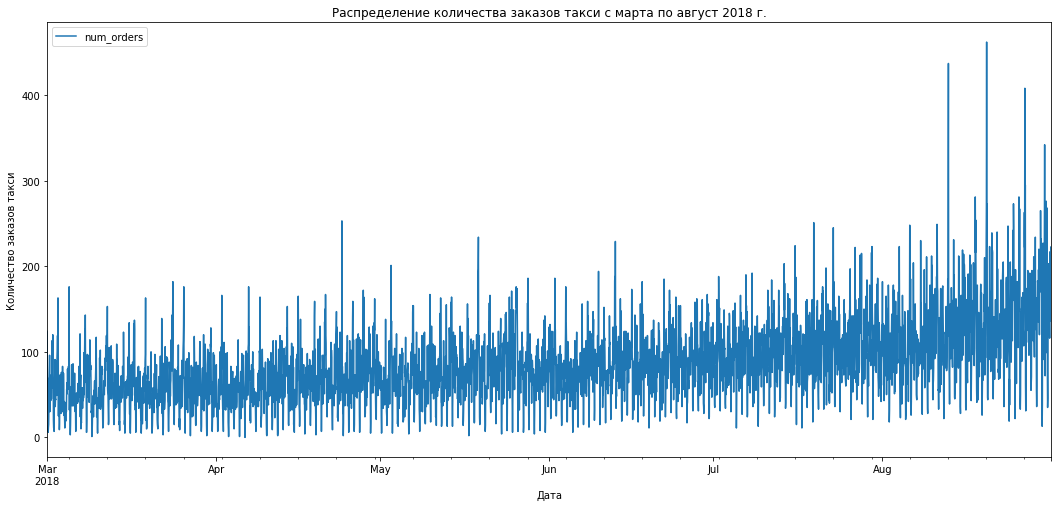

In [8]:
df.plot(figsize = (18, 8));

plt.xlabel('Дата')
plt.ylabel('Количество заказов такси')
plt.title("Распределение количества заказов такси с марта по август 2018 г.")
plt.legend(loc='upper left')
plt.show()

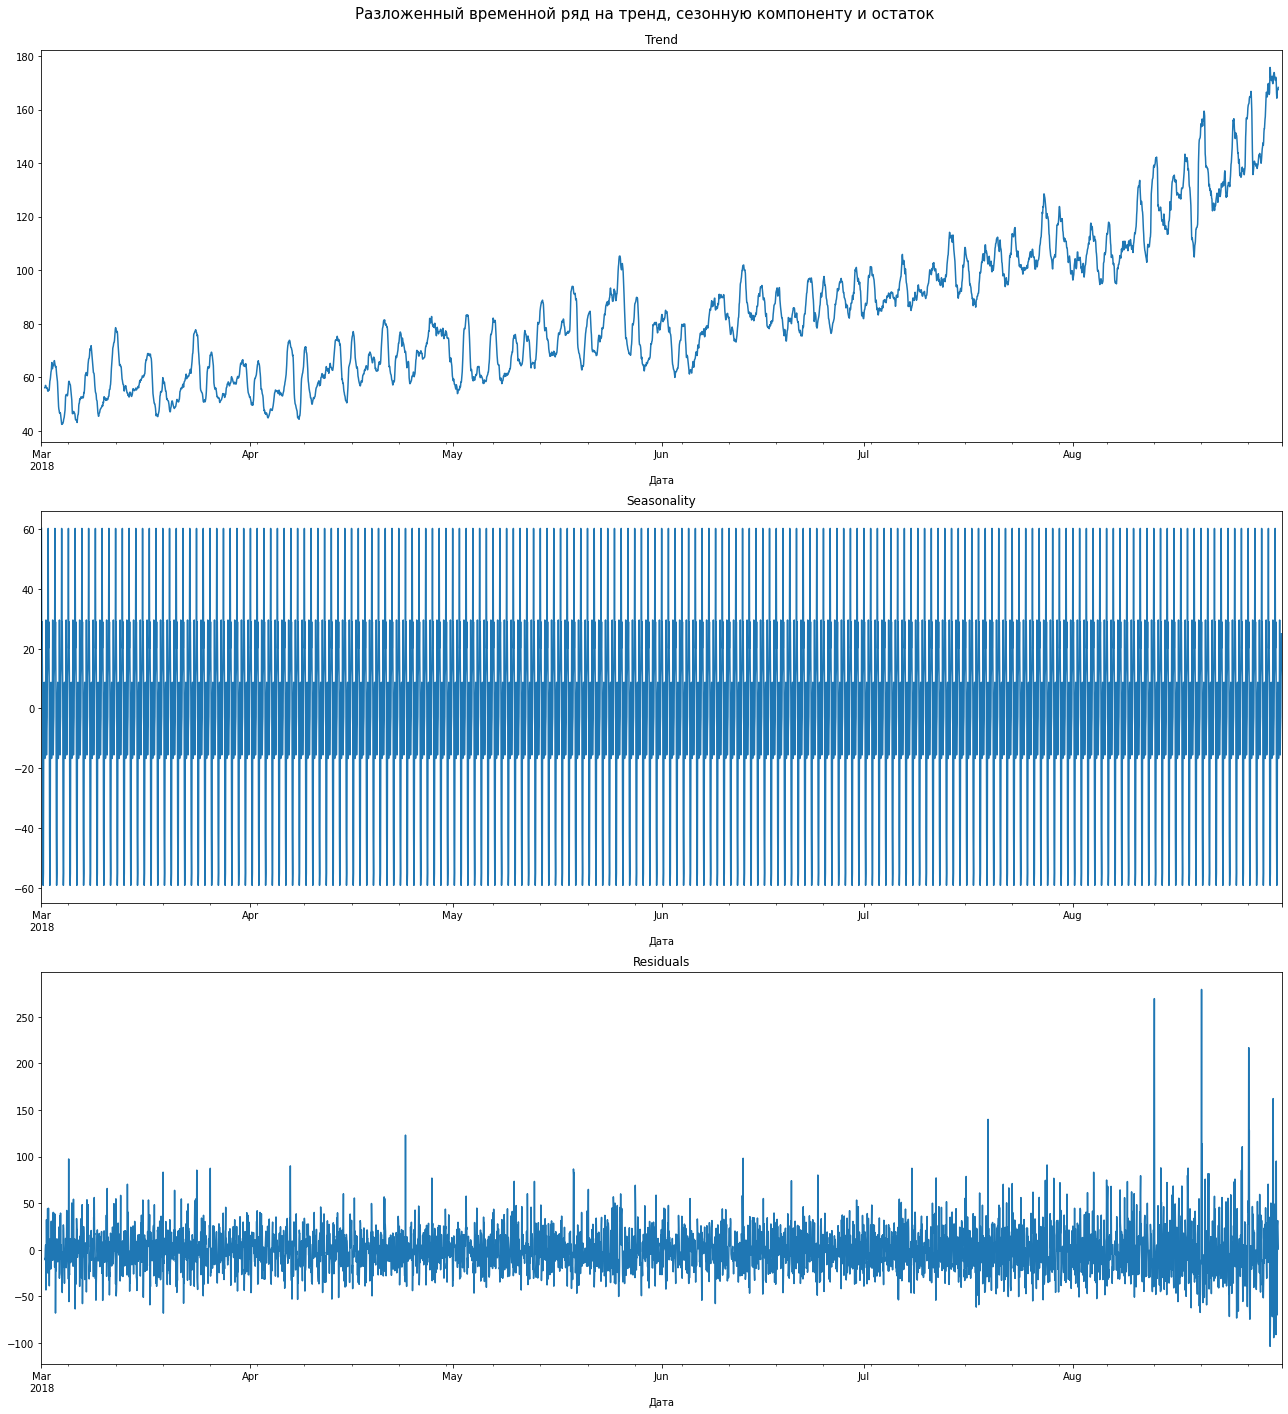

In [9]:
#Разложим временной ряд на тренд, сезонную компоненту и остаток.
decomposed = seasonal_decompose(df)
plt.figure(figsize=(18, 20))
plt.suptitle('Разложенный временной ряд на тренд, сезонную компоненту и остаток', fontsize=15)

# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca()

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.xlabel('Дата')
plt.title('Trend')


plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.xlabel('Дата')
plt.title('Seasonality')


plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.xlabel('Дата')
plt.title('Residuals')
plt.tight_layout()
plt.subplots_adjust(top=0.95)

In [10]:
 display('Количетсво пропусков по каждому столбцу:', df.isna().sum())

'Количетсво пропусков по каждому столбцу:'

num_orders    0
dtype: int64

In [11]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


**В датасете присутствуют данные о количестве заказов такси с 01.03.2018 по 31.08.2018, временной шаг 10 минут. Всего 26496 объектов. По данным графика количество заказов со временем, в среднем, неуклонно растет, отмечаются большая амплитуда колебаний значений, возможно есть определенная сезонность. Максимальное количество заказов за час составляет 462.**

## Анализ

In [12]:
#Посмотрим скользящее среднее и отобразим на графике
df_rolling_mean = df.copy()
df_rolling_mean['10'] = df.rolling(10, closed='left').mean()
df_rolling_mean['50'] = df.rolling(50, closed='left').mean()
df_rolling_mean['std'] = df.rolling(50, closed='left').std()

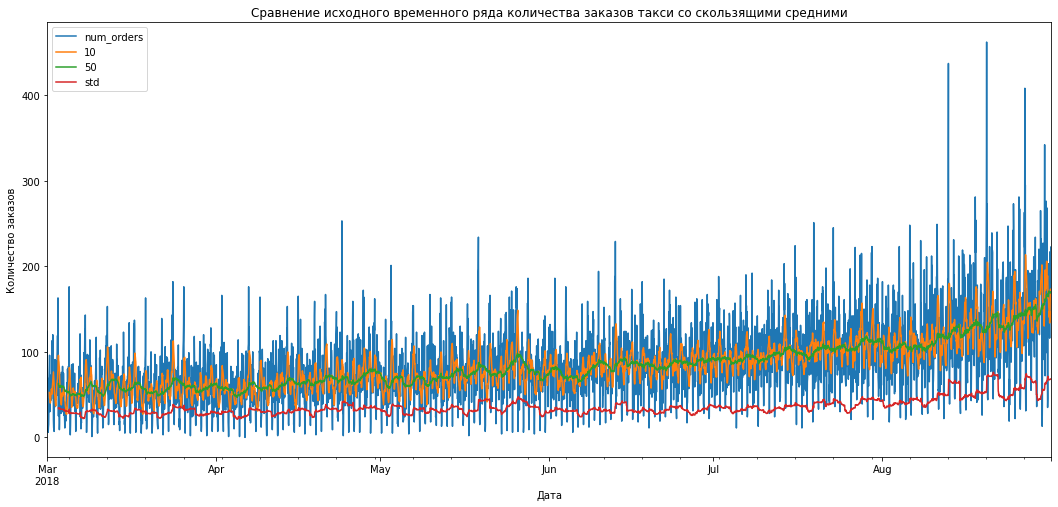

In [13]:
df_rolling_mean.plot(figsize = (18, 8));
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title("Сравнение исходного временного ряда количества заказов такси со скользящими средними")
plt.legend(loc='upper left')
plt.show();

**Отмечаются большие колебания в количестве заказов в зависимости от времени, для хорошего усреднения приходится увеличивать размер окна до 50. При этом веременной ряд не стационарный.**

In [16]:
# Проверим временной ряд на стационарность с помощью теста Дики-Фуллера
# Нулевая гипотеза - временной ряд не стационарен
# Альтернативная гипотеза - временной ряд стационарен

result = adfuller(df['num_orders'], autolag='AIC')

print('Критерий ADF: %f' % result[0])

print('P-значение: %f' % result[1])

print('Критические значения:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    if result[0] < result[4][key]:
        print ("Нулевая гипотеза отвергнута – Временной ряд стационарен")
    else:
        print ("Нулевая гипотеза не отвергнута – Временной ряд не стационарен")

Критерий ADF: -3.068924
P-значение: 0.028940
Критические значения:
	1%: -3.432
Нулевая гипотеза не отвергнута – Временной ряд не стационарен
	5%: -2.862
Нулевая гипотеза отвергнута – Временной ряд стационарен
	10%: -2.567
Нулевая гипотеза отвергнута – Временной ряд стационарен


**Получается нулевую гипотезу можно отвергнуть при уровне значимости 5 и 10%. При уровне значимости 1% нулевую гипотезу отвергнуть не можем, временной ряд не стационарен.**

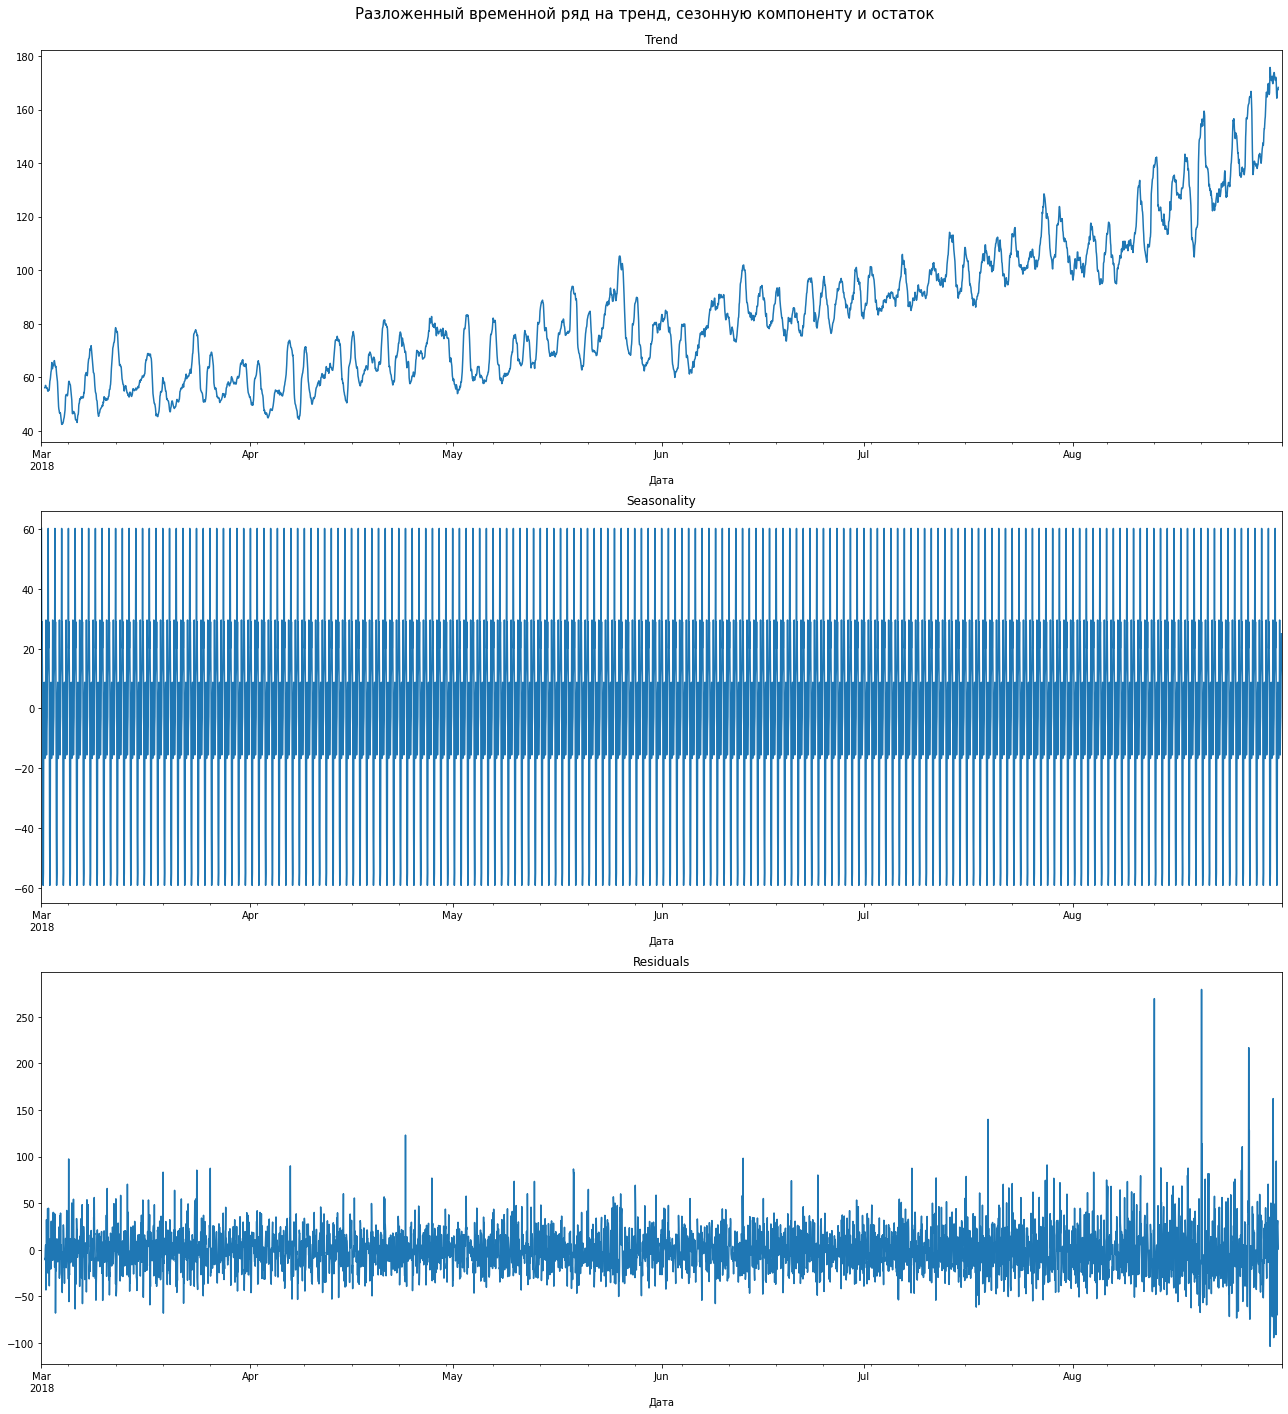

In [14]:
#Разложим временной ряд на тренд, сезонную компоненту и остаток.
decomposed = seasonal_decompose(df)
plt.figure(figsize=(18, 20))
plt.suptitle('Разложенный временной ряд на тренд, сезонную компоненту и остаток', fontsize=15)

# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.xlabel('Дата')
plt.title('Trend')


plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.xlabel('Дата')
plt.title('Seasonality')


plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.xlabel('Дата')
plt.title('Residuals')
plt.tight_layout()
plt.subplots_adjust(top=0.95)

**Видим, что сезонность проявляется в очень узком временном диапазоне, рассмотрим ее "поближе". Возьмем неделю в качестве исследуемого временного отрезка.**

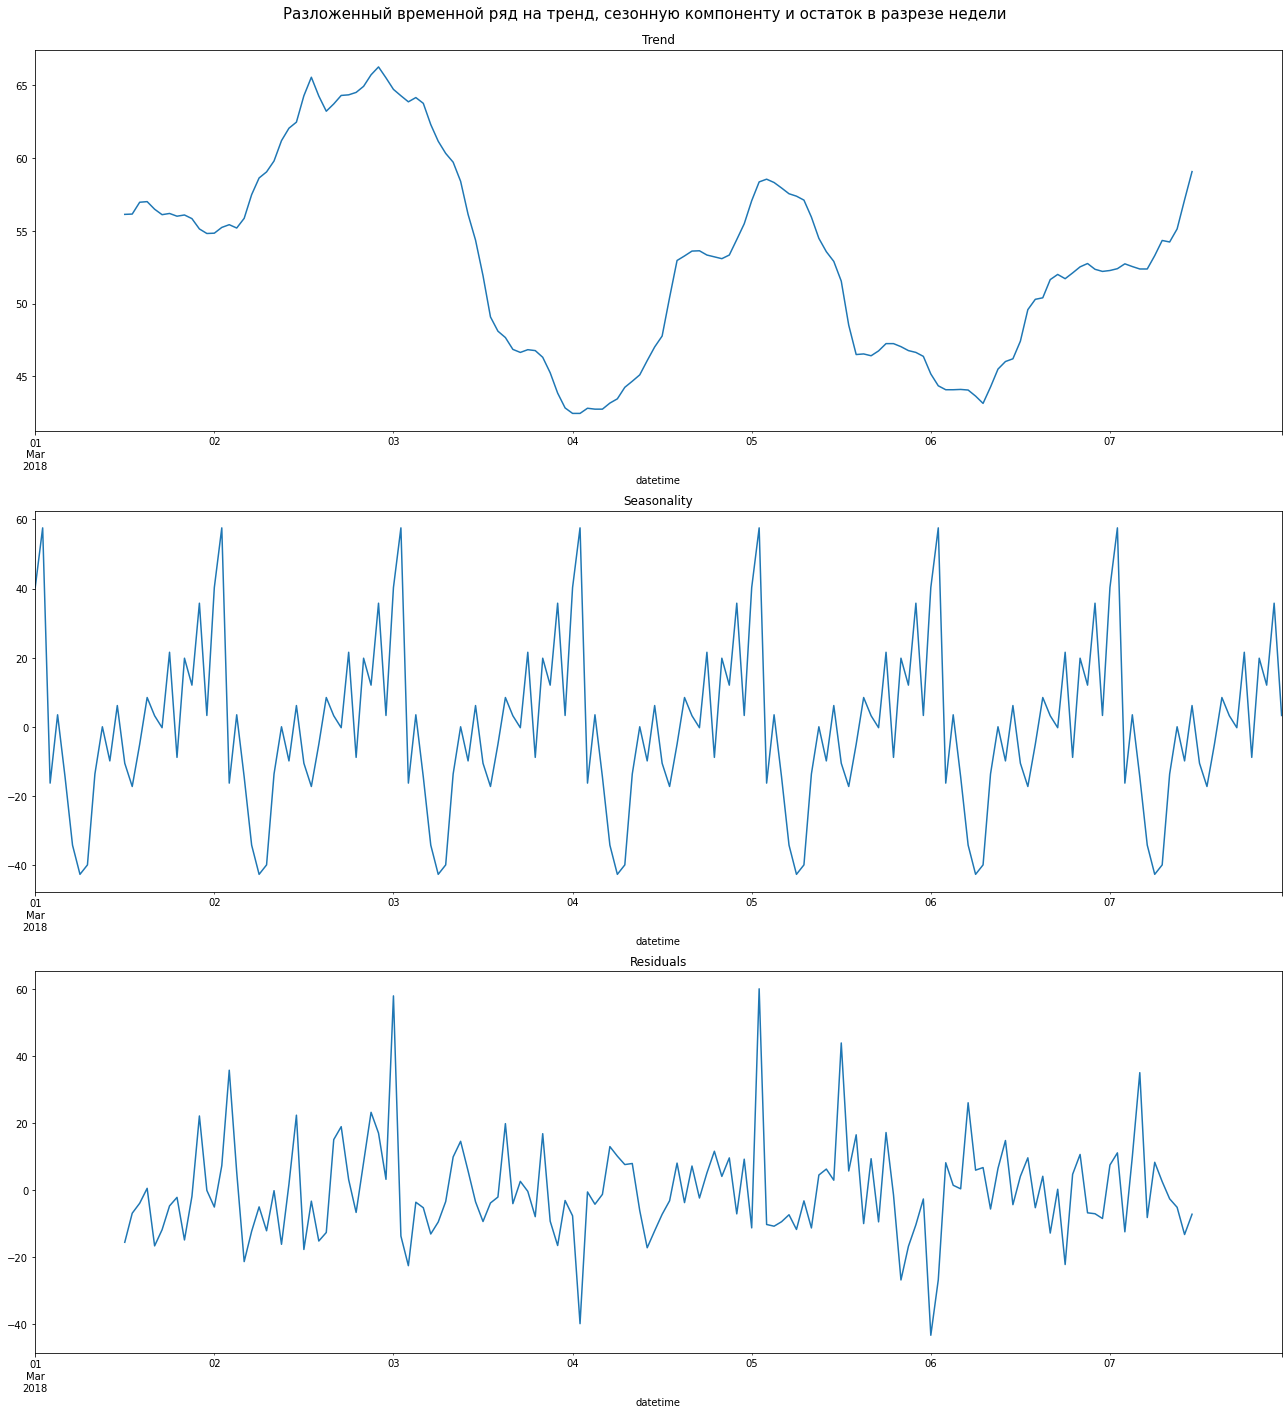

In [15]:
decomposed_week = seasonal_decompose(df['2018-03-01':'2018-03-07'])
plt.figure(figsize=(18, 20))
plt.suptitle('Разложенный временной ряд на тренд, сезонную компоненту и остаток в разрезе недели', fontsize=15)

plt.subplot(311)
decomposed_week.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_week.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed_week.resid.plot(ax=plt.gca()) 
plt.title('Residuals')

plt.tight_layout()
plt.subplots_adjust(top=0.95)

**Отмечается сезонность внутри одних суток.**

- На основе трендового графика отмечается рост числа заказов такси.
- Отмечается резкое снижение числа заказов в утренние часы, и значительный рост в вечерние-ночные часы, вероятно это связазно с пиковыми нагрузками на аэропорты, в вечерние часы прилетов больше всего.
- Также отмечается рост дисперсии.

**Напишем функцию для создания признаков.**

In [16]:
def make_features(df, max_lag, rolling_mean_size):
    df_make_features = df.copy()
#     df['month'] = df.index.month
    df_make_features['day'] = df_make_features.index.day
    df_make_features['dayofweek'] = df_make_features.index.dayofweek
    df_make_features['hour'] = df_make_features.index.hour
    
    for lag in range(1, max_lag + 1):
        df_make_features['lag_{}'.format(lag)] = df_make_features['num_orders'].shift(lag)

    df_make_features['rolling_mean'] = df_make_features['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df_make_features

**Применим данную функцию к нашему датасету, размер окна поставим 50, так как график скользящего среднего выглядит приемлемым при таком размере окна. А лаг поставим 24, так как сезонность суточная. Также в качестве признаков добавим день, день недели и час.**

In [17]:
df_new = make_features(df, 24, 50)

In [18]:
display(df.head())
display(df_new)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,31,4,19,207.0,217.0,197.0,116.0,133.0,166.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,169.64
2018-08-31 20:00:00,154,31,4,20,136.0,207.0,217.0,197.0,116.0,133.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,169.18
2018-08-31 21:00:00,159,31,4,21,154.0,136.0,207.0,217.0,197.0,116.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,169.86


In [19]:
#зафиксируем random_state
RS = 12345

In [20]:
train, test = train_test_split(df_new, shuffle=False, test_size=0.1)
#Удалим пропуски
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [21]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(3924, 28)
(442, 28)
(3924,)
(442,)


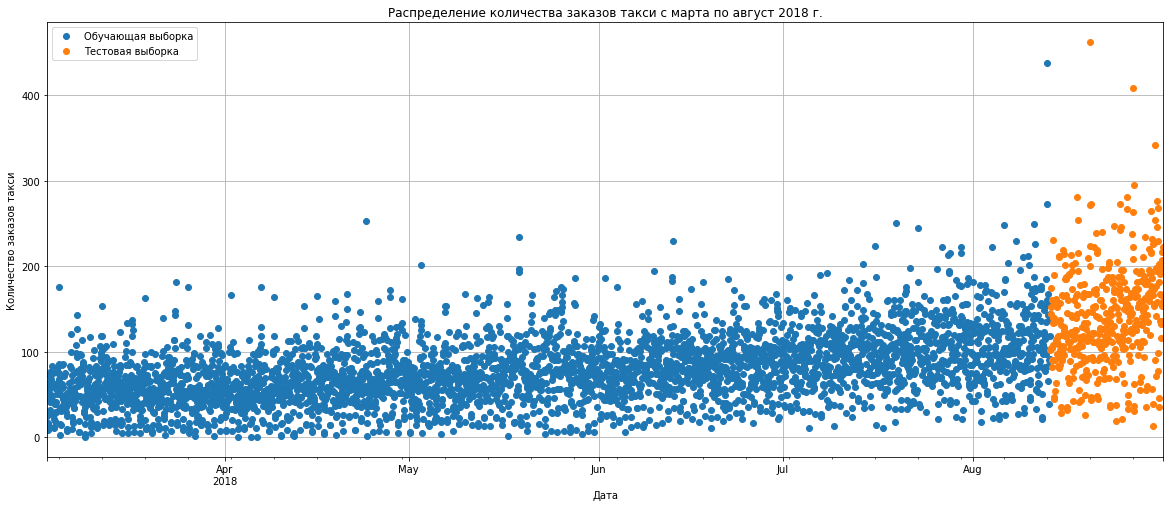

In [22]:
plt.figure(figsize=(15, 8))

target_train.plot(grid=True, style='o', figsize=(20, 8), label='Обучающая выборка');
target_test.plot(grid=True, style='o', figsize=(20, 8), label='Тестовая выборка');

plt.xlabel('Дата')
plt.ylabel('Количество заказов такси')
plt.title("Распределение количества заказов такси с марта по август 2018 г.")
plt.legend(loc='upper left')
plt.show()

**Данные не перемешаны и разбиты в нужном соотношении. Обучающую выборку делить на обучающую и валидационную не будем так как при обучении моделей будем применять кросс-валидацию.**

In [23]:
#Отмасштабируем признаки

scaler = StandardScaler()

features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

## Обучение

In [24]:
#создадим функию для расчета RMSE
def rmse(test, predict):
    return mean_squared_error(test, predict, squared=False).round(0)

**3.1. Обучим модель линейной регрессии.**

In [25]:
%%time

cv_tss = TimeSeriesSplit(n_splits=3).split(features_train)

model_lin = LinearRegression()
best_score_lin = round(
    cross_val_score(model_lin, features_train, target_train, cv=cv_tss, scoring='neg_root_mean_squared_error').mean()*-1, 
    2)
print('Квадратный корень из средней квадратичной ошибки RMSE для линейной регрессии:', best_score_lin)

Квадратный корень из средней квадратичной ошибки RMSE для линейной регрессии: 28.3
CPU times: user 176 ms, sys: 340 ms, total: 516 ms
Wall time: 479 ms


**3.2. Обучим модель случайного леса.**

In [26]:
parameters_forest = {'n_estimators': range(10, 51, 10),
                     'max_depth': range(1, 10), 
                     'min_samples_leaf': range(1,6)}

In [27]:
%%time
cv_tss = TimeSeriesSplit(n_splits=3).split(features_train)
model_forest = RandomForestRegressor(random_state=RS)
grid_forest = GridSearchCV(model_forest, parameters_forest, cv=cv_tss, scoring='neg_root_mean_squared_error')
grid_forest.fit(features_train, target_train)

CPU times: user 3min 22s, sys: 314 ms, total: 3min 22s
Wall time: 3min 23s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fcc1cfcbf90>,
             estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 6),
                         'n_estimators': range(10, 51, 10)},
             scoring='neg_root_mean_squared_error')

In [28]:
best_parameters_forest = grid_forest.best_params_
best_score_forest = round(grid_forest.best_score_*-1, 2)
print('Лучшие гиперпараметры для модели случайного леса:', best_parameters_forest)
print('Квадратный корень из средней квадратичной ошибки RMSE для случайного леса:', best_score_forest)

Лучшие гиперпараметры для модели случайного леса: {'max_depth': 9, 'min_samples_leaf': 3, 'n_estimators': 20}
Квадратный корень из средней квадратичной ошибки RMSE для случайного леса: 27.65


**3.3. Обучим модель CatBoostRegressor.**

In [29]:
parameters_cbr = {'learning_rate': np.logspace(-2, 0, 4),
                  'depth': range(10, 41, 10),
                  'n_estimators': range(10, 51, 10)}

In [30]:
%%time
cv_tss = TimeSeriesSplit(n_splits=3).split(features_train)
grid_cbr = GridSearchCV(CatBoostRegressor(loss_function='RMSE',
                                          silent=True,                                                                                 
                                          random_state=RS),
                        parameters_cbr,
                        scoring='neg_root_mean_squared_error',
                        cv=cv_tss)
grid_cbr.fit(features_train, target_train)

CPU times: user 1min 24s, sys: 385 ms, total: 1min 25s
Wall time: 2min 17s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fcc1cfcb2e0>,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fcc1c7ad040>,
             param_grid={'depth': range(10, 41, 10),
                         'learning_rate': array([0.01      , 0.04641589, 0.21544347, 1.        ]),
                         'n_estimators': range(10, 51, 10)},
             scoring='neg_root_mean_squared_error')

In [31]:
best_parameters_cbr = grid_cbr.best_params_
best_score_cbr = round(grid_cbr.best_score_*-1, 2)
print('Лучшие гиперпараметры для модели CatBoostRegressor:', best_parameters_cbr)
print('Квадратный корень из средней квадратичной ошибки RMSE для CatBoostRegressor:', best_score_cbr)

Лучшие гиперпараметры для модели CatBoostRegressor: {'depth': 10, 'learning_rate': 0.21544346900318834, 'n_estimators': 50}
Квадратный корень из средней квадратичной ошибки RMSE для CatBoostRegressor: 28.65


**3.4 Обучим модель LGBMRegressor.**

In [32]:
parameters_lgbm = {'num_leaves': range(20, 41, 10),
                   'max_depth': range(10, 41, 10),
                   'n_estimators': range(10, 51, 10)}

In [33]:
%%time
cv_tss = TimeSeriesSplit(n_splits=3).split(features_train)
grid_lgbm = GridSearchCV(LGBMRegressor(random_state=RS), parameters_lgbm, scoring='neg_root_mean_squared_error', cv=cv_tss)
grid_lgbm.fit(features_train, target_train)

CPU times: user 1h 32min 51s, sys: 40.4 s, total: 1h 33min 32s
Wall time: 1h 34min 12s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fcc1cc0dc80>,
             estimator=LGBMRegressor(random_state=12345),
             param_grid={'max_depth': range(10, 41, 10),
                         'n_estimators': range(10, 51, 10),
                         'num_leaves': range(20, 41, 10)},
             scoring='neg_root_mean_squared_error')

In [34]:
best_parameters_lgbm = grid_lgbm.best_params_
best_score_lgbm = round(grid_lgbm.best_score_*-1, 2)
print('Лучшие гиперпараметры для модели LGBMRegressor:', best_parameters_lgbm)
print('Квадратный корень из средней квадратичной ошибки RMSE для LGBMRegressor:', best_score_lgbm)

Лучшие гиперпараметры для модели LGBMRegressor: {'max_depth': 20, 'n_estimators': 50, 'num_leaves': 20}
Квадратный корень из средней квадратичной ошибки RMSE для LGBMRegressor: 26.89


In [35]:
#занесем результаты в отдельный датафрейм
model_type = ['Linear Regression', 'Random Forest Regressor', 'CatBoostRegressor', 'LGBMRegressor']
RMSE = [best_score_lin, best_score_forest, best_score_cbr, best_score_lgbm]



result = pd.DataFrame({'Model Type': model_type,
                           'RMSE': RMSE})

result

,Model Type,RMSE
0,Linear Regression,28.30
1,Random Forest Regressor,27.65
2,CatBoostRegressor,28.65
3,LGBMRegressor,26.89


**Наименьшее значение RMSE получилось у модели LGBMRegressor, однако у нее и самое большое время обучения. Для текущей задачи это не принципиально, поэтому протестируем данную модель на тестовой выборке.**

## Тестирование

**Протестируем модель LGBMRegressor на тестовой выборке.**

In [36]:
%%time

model_lgbm = grid_lgbm.best_estimator_
# model_lgbm = LGBMRegressor(max_depth=20, n_estimators=50, num_leaves=30)
model_lgbm.fit(features_train, target_train)

CPU times: user 413 ms, sys: 7.86 ms, total: 421 ms
Wall time: 331 ms


LGBMRegressor(max_depth=20, n_estimators=50, num_leaves=20, random_state=12345)

In [37]:
predictions_test_lgbm = model_lgbm.predict(features_test)
result_lgbm = rmse(target_test, predictions_test_lgbm)

print('Квадратный корень из средней квадратичной ошибки RMSE для LGBMRegressor на тестовой выборке:', result_lgbm)

Квадратный корень из средней квадратичной ошибки RMSE для LGBMRegressor на тестовой выборке: 43.0


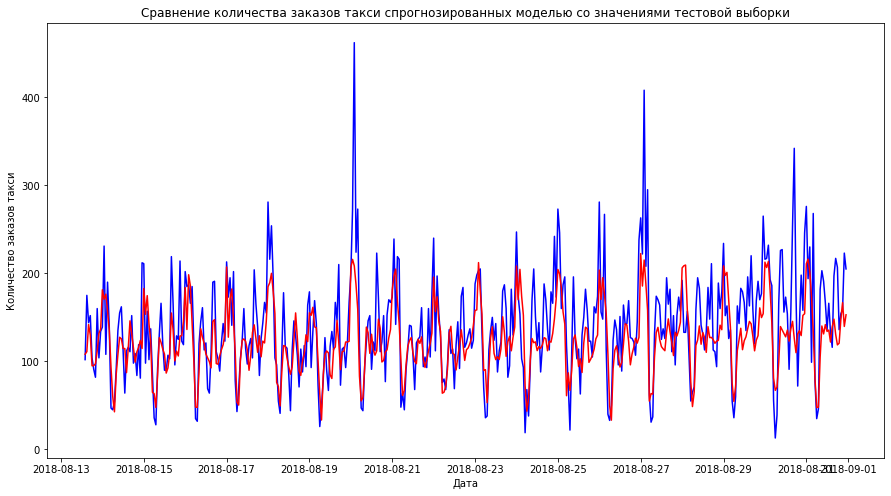

In [39]:
#Визуализируем полученные данные и сравним с тестовой выборкой
plt.figure(figsize=(15, 8))
plt.plot(target_test.index, 
         target_test, 
         'b-', 
         target_test.index, 
         predictions_test_lgbm,
         'r-')

plt.xlabel('Дата')
plt.ylabel('Количество заказов такси')
plt.title("Сравнение количества заказов такси спрогнозированных моделью со значениями тестовой выборки")
plt.show()

**В целом, модель предсказывает количество заказов такси достаточно хорошо, особенно ее сезонность. Однако определенные пики в значениях предсказать ей не удалось. RMSE для LGBMRegressor на тестовой выборке составил 43, что меньше необходимого значения (48).**

**Сравним лучшую модель с константной моделью.**

In [42]:
model_dummy = DummyRegressor(strategy="median")
model_dummy.fit(features_train, target_train)
dummy_pred = model_dummy.predict(features_test)
RMSE_dummy = rmse(target_test, dummy_pred)

print("Квадратный корень из средней квадратичной ошибки RMSE для на dummy модели:", RMSE_dummy)

Квадратный корень из средней квадратичной ошибки RMSE для на dummy модели: 87.0


**Финальная оценка RMSE на тестовой выборке составила 43, что меньше финальнай оценки RMSE на Dummy модели (87), что указывает на адекватность нашей модели.**

## Общий вывод

**В результате анализа общей информации выявлено следующее:**
- В датасете присутствуют данные о количестве заказов такси с 01.03.2018 по 31.08.2018, временной шаг 10 минут. Всего 26496 объектов. Максимальное количество заказов за час составляет 462.
- Отмечаются большие колебания в количестве заказов в зависимости от времени, для хорошего усреднения приходится увеличивать размер окна до 50. При этом веременной ряд не стационарный.
- Отмечается сезонность внутри одних суток.
- На основе трендового графика отмечается рост числа заказов такси.
- Отмечается резкое снижение числа заказов в утренние часы, и значительный рост в вечерние-ночные часы, вероятно это связазно с пиковыми нагрузками на аэропорты, в вечерние часы прилетов больше всего.
- Также отмечается рост дисперсии.
- График скользящего среднего выглядит приемлемым с размером окна 50. Для создания признаков применен данный размер окна, а лаг взят равным 24, так как сезонность суточная. Также в качестве признаков добавлены день, день недели и час.

**Модели:**

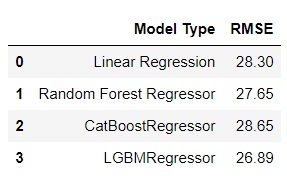

- В результате обучения моделей наилучшей оказалась модель LGBMRegressor со следующими гиперпараметрами: 
    количество деревьев 'Estimators' лучшей модели - 50, глубина 'Max_depth' лучшей модели - 20, количество листьев 'num_leaves' - 20.
- Финальная оценка RMSE на тестовой выборке составила 43, что меньше необходимого значения (48).
- Модель прошла проверку на адекватность при сравнении с константной моделью.